## Initial Imports
Loading Neuron files is annoying and will bug out if loaded twice, so it is loaded at the top to guarantee it will only run once.

In [1]:
from neuron import h
from cell_inference.config import params, paths
import pandas as pd

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

## Detailed Cell
First we generate the LFP heatmap and summary stats for the Detailed Cell Example. We have the detailed cell parameters specified and run via bmtk in another repository (detailed-single-cell). Therefore, we simply load the .h5 file containing the recorded LFP and generate summary stats from it to compare directly with the stylized model.

The detailed cell parameters are (Parameters marked with ^ are estimations, will be confirmed later):

| Model Number | $y$   | $d$  | $\theta$        | $h$                       | $\varphi$ | $r_s$ | $\ell_t$ | $r_t$ | $\ell_d$ |
|--------------|-------|------|-----------------|---------------------------|-----------|-------|----------|-------|----------|
| 497229089    | 350.0 | 80.0 | $\frac{\pi}{2}$ | 0.0, $\frac{\pi}{4}$, 1.0 | 0.0       | 8.0^  | 200.0^   | 1.25^ | 200.0^   |
| 496930324    | 350.0 | 80.0 | $\frac{\pi}{2}$ | 0.0, $\frac{\pi}{4}$, 1.0 | 0.0       | 8.0^  | 400.0^   | 1.25^ | 200.0^   |

In [2]:
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
import os
import h5py
import numpy as np

DATA_PATH = 'cell_inference/resources/invivo'
COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

detailed_cells = [
    os.path.join(DATA_PATH, 'neuronal_model_497229089_h0.0.h5'),
    os.path.join(DATA_PATH, 'neuronal_model_497229089_h0.7071.h5'),
    os.path.join(DATA_PATH, 'neuronal_model_497229089_h1.0.h5'),
    os.path.join(DATA_PATH, 'neuronal_model_496930324_h0.0.h5'),
    os.path.join(DATA_PATH, 'neuronal_model_496930324_h0.7071.h5'),
    os.path.join(DATA_PATH, 'neuronal_model_496930324_h1.0.h5')
]

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
data = []
bad_indices = []
summ_stats = []
y_pos = []
coordinates = []

for i, sample in enumerate(detailed_cells):
    with h5py.File(sample, "r") as f:
        #     c = f['coord'][:]
        lfp = f['data'][:].reshape((-1, 384))

    fst_idx = first_pk_tr(lfp)
    start, end = get_spike_window(lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    try:
        g_lfp, g_coords, y_i = build_lfp_grid(lfp[start:end,:], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    summ_stats.append(calculate_stats(g_lfp))
    y_pos.append(y_i)
    coordinates.append(g_coords)
    data.append(pd.DataFrame(data=g_lfp, columns=list(['Condensed Channel {}'.format(i) for i in range(196)])))  # time x channels

# ids = np.delete(ids, bad_indices, axis=0)
coordinates = np.stack(coordinates, axis=0)
summ_stats = pd.DataFrame(data=np.array(summ_stats), columns=list(['Summary Stat {}'.format(i) for i in range(40)]))
y_pos = np.stack(y_pos, axis=0)
summ_stats

,Summary Stat 0,Summary Stat 1,Summary Stat 2,Summary Stat 3,Summary Stat 4,Summary Stat 5,Summary Stat 6,Summary Stat 7,Summary Stat 8,Summary Stat 9,...,Summary Stat 30,Summary Stat 31,Summary Stat 32,Summary Stat 33,Summary Stat 34,Summary Stat 35,Summary Stat 36,Summary Stat 37,Summary Stat 38,Summary Stat 39
0,-0.000040,0.000107,3.0,31.0,0.000021,0.0,24.0,-0.000606,-35.433673,84.729947,...,0.001144,16.0,56.0,130.0,22.0,28.0,22.0,26.0,33.0,27.0
1,-0.000007,0.000068,2.0,30.0,0.000139,0.0,24.0,-0.000240,-27.755102,82.903935,...,0.000505,16.0,42.0,117.0,21.0,27.0,21.0,26.0,31.0,26.0
2,0.000032,0.000068,1.0,23.0,0.000234,0.0,16.0,-0.000043,-23.729592,63.358660,...,0.000847,16.0,34.0,68.0,20.0,27.0,20.0,28.0,22.0,27.0
3,0.000003,0.000011,2.0,26.0,0.000033,0.0,24.0,-0.000059,37.811224,41.020777,...,0.000282,16.0,33.0,78.0,21.0,25.0,22.0,26.0,32.0,22.0
4,0.000006,0.000019,1.0,24.0,0.000069,0.0,19.0,-0.000033,51.433673,49.333214,...,0.000364,16.0,42.0,79.0,21.0,28.0,21.0,28.0,26.0,21.0
5,0.000011,0.000021,2.0,24.0,0.000085,0.0,14.0,-0.000005,20.005102,78.931222,...,0.000463,16.0,38.0,78.0,21.0,27.0,21.0,28.0,25.0,21.0


## Stylized Cell
Next we rebuild and simulate the stylized cell model. The parameters are set to the same as the detailed model.

In [3]:
from scipy.interpolate import LinearNDInterpolator
from cell_inference.utils.transform.geometry_transformation import cart2pol
from typing import Dict

loc_param_list = ['x','y','z','alpha','h','phi']
geo_param_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu','l_d']

loc_param_default = {'x': 0., 'y': 350., 'z': 80.,
                     'alpha': np.pi / 4, 'h': 1., 'phi': 0.,
                     'd': (cart2pol(0, 50))[0], 'theta': (cart2pol(0, 50))[1]
                     }

geo_param_default = {'r_s': 8., 'l_t': 200., 'r_t': 1.25,
                     'r_d': .28, 'r_tu': .28, 'l_d': 200.
                     }

gmax_mapping = h5py.File(paths.GMAX_MAPPING, 'r')

geo_list = [geo_param_list[idx] for idx in gmax_mapping['settings/geo_index']]
squared_soma_radius = gmax_mapping['mapping'].attrs['squared_soma_radius']

# Use linear interpolation
gmax_interp = LinearNDInterpolator(gmax_mapping['mapping/geometry'][()], gmax_mapping['mapping/gmax'][()])

gmax_mapping.close()

def pred_gmax(geo_samples: Dict):
    geo = []
    for key in geo_list:
        if squared_soma_radius and key == 'r_s':
            geo.append(geo_samples[key]**2)
        else:
            geo.append(geo_samples[key])
    gmax = gmax_interp(np.column_stack(geo))
    #     gmax = clf.predict(np.column_stack(geo))
    return gmax

gmax = pred_gmax(geo_param_default)

# loc_params = np.array([[0., 350., 80., np.pi / 4, 0.0000,0.],
#                        [0., 350., 80., np.pi / 4, 0.7071,0.],
#                        [0., 350., 80., np.pi / 4, 1.0000,0.],
#                        [0., 350., 80., np.pi / 4, 0.0000,0.],
#                        [0., 350., 80., np.pi / 4, 0.7071,0.],
#                        [0., 350., 80., np.pi / 4, 1.0000,0.]])


"""
 |
-o-
 |
 _
"""

# Plot morphology and find position where cell touches electrode 4.11.22
loc_params = np.array([[0., 350., 150., 1, 0.7071,0.],
                       [0., 350., 150., np.pi / 12, 0.7071,0.],
                       [0., 350., 150., np.pi / 10, 0.7071,0.],
                       [0., 350., 150., np.pi /  8, 0.7071,0.],
                       [0., 350., 150., np.pi /  6, 0.7071,0.],
                       [0., 350., 150., np.pi / 4, 0.7071,0.]])

geo_params = np.array([[8., 200., 1.25, 1.28, .28, 200.],
                       [8., 200., 1.25, 1.28, .28, 200.],
                       [8., 200., 1.25, 1.28, .28, 200.],
                       [8., 400., 1.25, 1.28, .28, 200.],
                       [8., 400., 1.25, 1.28, .28, 200.],
                       [8., 400., 1.25, 1.28, .28, 200.]])

# loc_params = np.tile(np.fromiter(loc_param_default.values(), dtype=float), (6,1))
# geo_params = np.tile(np.fromiter(geo_param_default.values(), dtype=float), (6,1))
gmax = np.tile(gmax, (6,1))

In [4]:
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes

sim = Simulation(geometry = geo_standard,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE,
                 loc_param = loc_params,
                 geo_param = geo_params,
                 spike_threshold = -30,
                 gmax = gmax,
                 scale = 1.,
                 ncell = 6)

sim.run_neuron_sim()

/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/cells/activecell.py:103: UserWarning: Error: gbar_Kv3 not found in <cell_inference.cells.activecell.ActiveCell object at 0x7fbaa3c8bbe0>.soma
  warnings.warn("Error: {} not found in {}".format(entry[1], sec))
/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/cells/activecell.py:103: UserWarning: Error: gbar_Kv3 not found in <cell_inference.cells.activecell.ActiveCell object at 0x7fbaa3c8bbe0>.basal
  warnings.warn("Error: {} not found in {}".format(entry[1], sec))
/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/cells/activecell.py:103: UserWarning: Error: gbar_Kv3 not found in <cell_inference.cells.activecell.ActiveCell object at 0x7fbaa3c8bbe0>.apical
  warnings.warn("Error: {} not found in {}".format(entry[1], sec))
/home/matt/PycharmProjects/Stylized-Cell-Inference/cell_inference/cells/activecell.py:103: UserWarning: Error: gbar_Kv3 not found in <cell_inference.cells.activecell.Active

In [5]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from typing import Union, List, Tuple

%matplotlib inline

def plot_v(sim: Simulation, cell_idx: np.ndarray = None,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    if cell_idx is None:
        cell_idx = np.arange(sim.ncell)
    elif cell_idx.size == 0:
        return
    t = sim.t()
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    axs = np.asarray(axs).ravel()
    for i, ax in enumerate(axs):
        ax.plot(t, sim.v(cell_idx[i]), label="cell %d" % (cell_idx[i]))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs

def invalid_index(sim):
    # index of valid spiking cells
    nspk, tspk = sim.get_spike_number('all')
    invalid = np.nonzero(nspk != 1)[0]
    return invalid, tspk

invalid_idx, tspk = invalid_index(sim)
print("Number of invalid samples: %d out of %d" % (invalid_idx.size, 6))

_ = plot_v(sim, cell_idx=invalid_idx)

mem_volt = sim.v('all')

Number of invalid samples: 0 out of 6


In [6]:
from scipy import signal

lfp = sim.get_lfp('all').transpose((0,2,1))  # (cells x channels x time) -> (cells x time x channels)

filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)  # filter along time axis

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(6):
    #     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[i])
    start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[i,start:end,:])

windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
print(windowed_lfp.shape)

(6, 176, 384)


In [7]:
sty_data = []
sty_bad_indices = []
sty_summ_stats = []
sty_y_pos = []
sty_coordinates = []

for i, j in enumerate(range(windowed_lfp.shape[0])):

    try:
        g_lfp, g_coords, y_i = build_lfp_grid(np.squeeze(windowed_lfp[j,:,:]), params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    sty_summ_stats.append(calculate_stats(g_lfp))
    sty_y_pos.append(y_i)
    sty_coordinates.append(g_coords)
    sty_data.append(pd.DataFrame(data=g_lfp, columns=list(['Condensed Channel {}'.format(i) for i in range(196)])))  # time x channels

# ids = np.delete(ids, bad_indices, axis=0)
sty_coordinates = np.stack(sty_coordinates, axis=0)
print(sty_coordinates.shape)
sty_summ_stats = pd.DataFrame(data=np.array(sty_summ_stats), columns=list(['Summary Stat {}'.format(i) for i in range(40)]))
sty_y_pos = np.stack(sty_y_pos, axis=0)
sty_summ_stats

(6, 196, 2)


,Summary Stat 0,Summary Stat 1,Summary Stat 2,Summary Stat 3,Summary Stat 4,Summary Stat 5,Summary Stat 6,Summary Stat 7,Summary Stat 8,Summary Stat 9,...,Summary Stat 30,Summary Stat 31,Summary Stat 32,Summary Stat 33,Summary Stat 34,Summary Stat 35,Summary Stat 36,Summary Stat 37,Summary Stat 38,Summary Stat 39
0,-0.000040,0.000051,0.0,39.0,0.000024,3.0,24.0,-0.000190,-8.816327,22.761786,...,0.007486,16.0,27.0,28.0,17.0,29.0,19.0,31.0,9.0,25.0
1,-0.000068,0.000088,3.0,41.0,0.000021,0.0,24.0,-0.000574,-10.178571,23.442151,...,0.019197,16.0,29.0,41.0,22.0,26.0,22.0,26.0,32.0,24.0
2,-0.000062,0.000079,3.0,41.0,0.000022,0.0,24.0,-0.000494,-9.903061,23.568090,...,0.016353,16.0,28.0,41.0,22.0,27.0,22.0,27.0,30.0,23.0
3,-0.000053,0.000066,3.0,41.0,0.000021,0.0,24.0,-0.000370,-10.255102,22.607255,...,0.012457,16.0,30.0,43.0,22.0,27.0,22.0,27.0,32.0,23.0
4,-0.000043,0.000054,3.0,39.0,0.000023,0.0,24.0,-0.000240,-8.948980,22.665884,...,0.008726,16.0,28.0,44.0,19.0,28.0,20.0,27.0,7.0,25.0
5,-0.000036,0.000048,2.0,39.0,0.000024,3.0,24.0,-0.000131,-8.974490,21.921808,...,0.006033,16.0,25.0,28.0,14.0,28.0,19.0,31.0,12.0,27.0


## Plotting and Comparison
Now we can plot and comare the parameters between the detailed and stylized cells.

In [8]:
t = np.arange(pk_tr_idx_in_window, data[0].to_numpy().shape[0]+pk_tr_idx_in_window)

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) &
         (g_coords[:,1]>=ylim[0]) &
         (g_coords[:,1]<=ylim[1]))

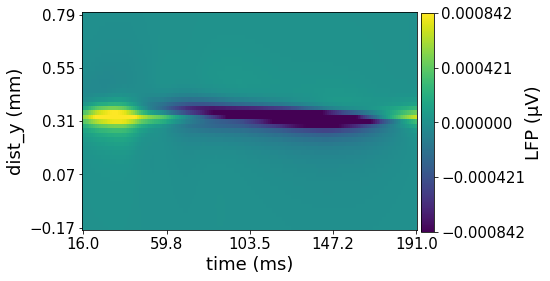

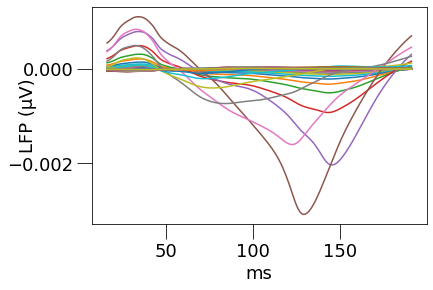

<Figure size 432x288 with 0 Axes>

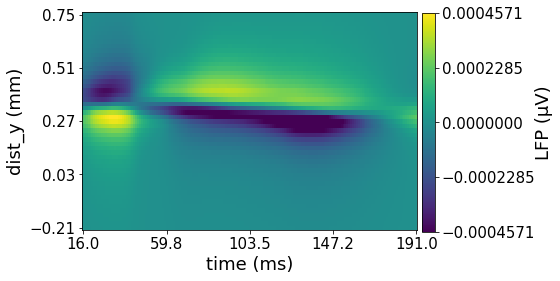

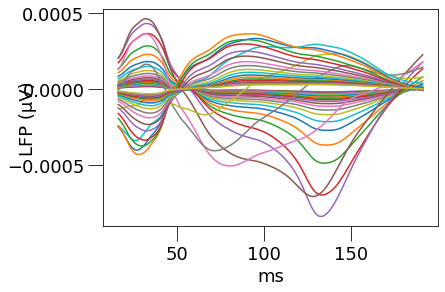

<Figure size 432x288 with 0 Axes>

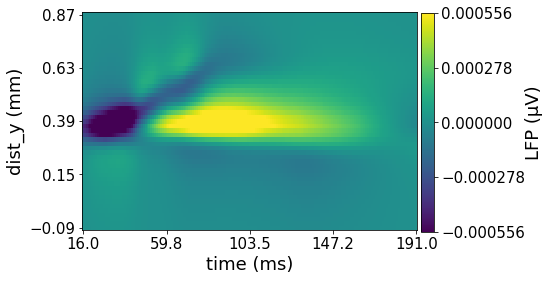

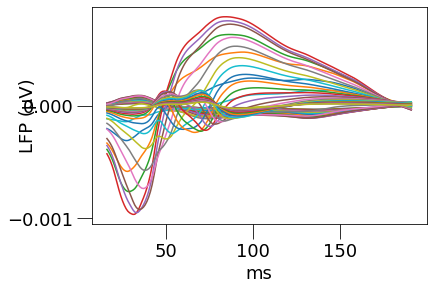

<Figure size 432x288 with 0 Axes>

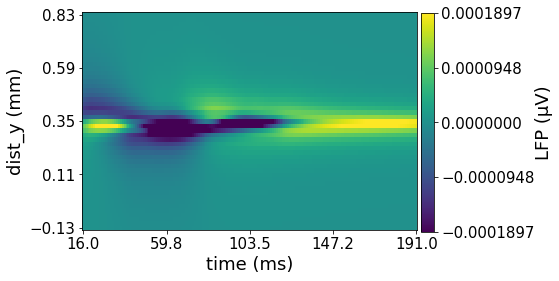

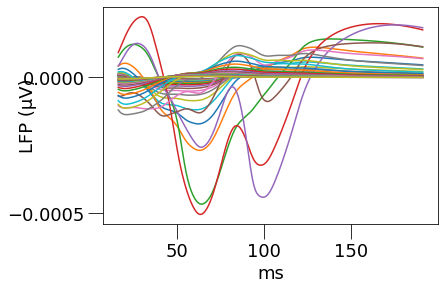

<Figure size 432x288 with 0 Axes>

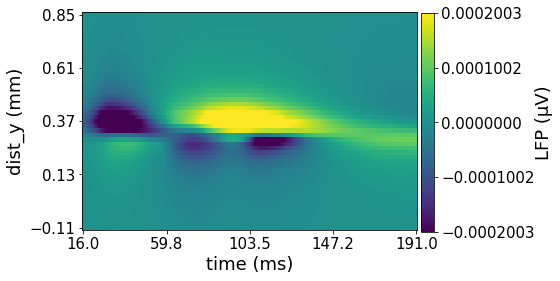

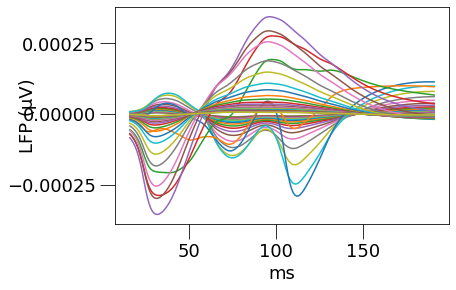

<Figure size 432x288 with 0 Axes>

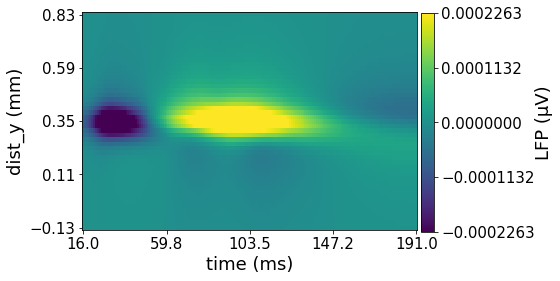

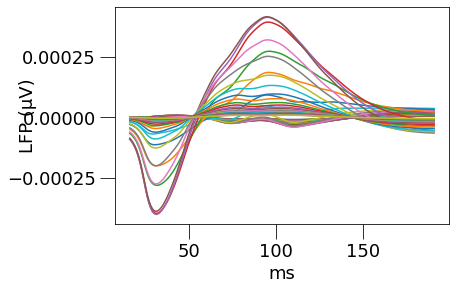

<Figure size 432x288 with 0 Axes>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from importlib import reload
import cell_inference.utils.plotting.plot_results
reload(cell_inference.utils.plotting.plot_results)
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap
from cell_inference.utils.plotting.plot_results import plot_lfp_traces


for j, df in enumerate(data):
    #     In Vivo Plot
    fig, ax = plot_lfp_heatmap(t=t,
                               elec_d=coordinates[j, e_idx, 1],
                               lfp=df.to_numpy()[:,e_idx],
                               vlim='auto',
                               fontsize=18, labelpad=0, ticksize=15, nbins=5
                               )

    fig, ax = plot_lfp_traces(t, df.to_numpy()[:,e_idx], fontsize=18)


    plt.tight_layout()

    # plt.savefig('lfp_heatmaps/' + 'detailed_groundtruth' + '.jpg')
#     if i == 22:
#         break
plt.show()

<Figure size 1080x288 with 0 Axes>

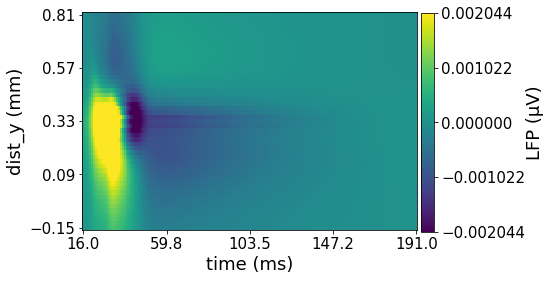

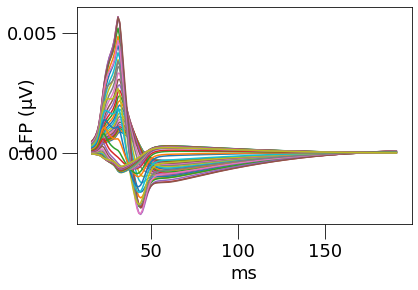

<Figure size 432x288 with 0 Axes>

<Figure size 1080x288 with 0 Axes>

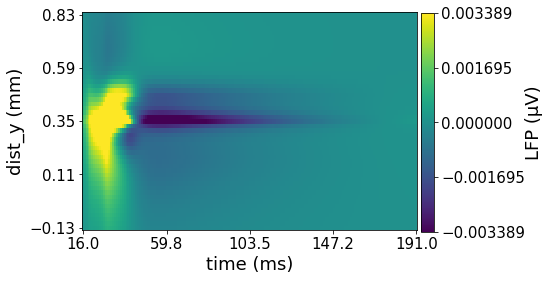

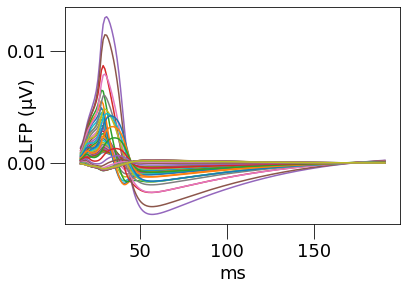

<Figure size 432x288 with 0 Axes>

<Figure size 1080x288 with 0 Axes>

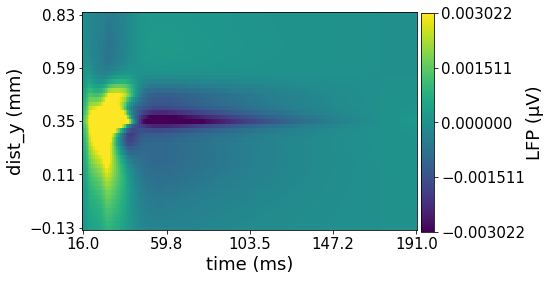

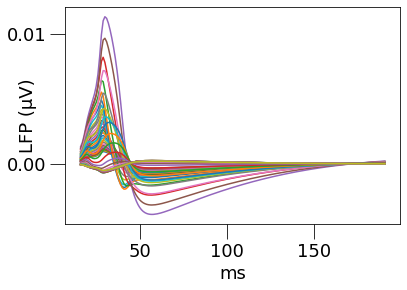

<Figure size 432x288 with 0 Axes>

<Figure size 1080x288 with 0 Axes>

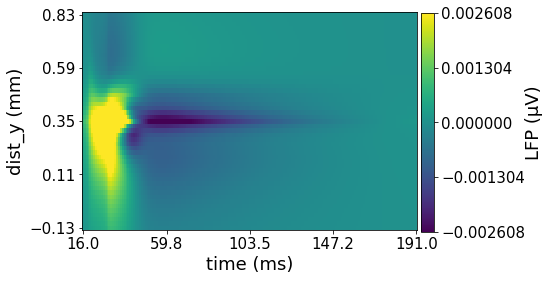

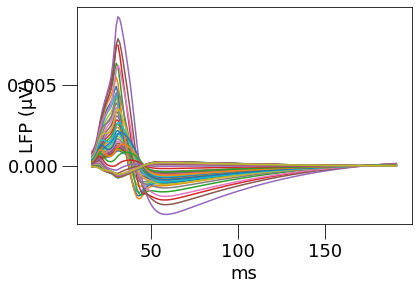

<Figure size 432x288 with 0 Axes>

<Figure size 1080x288 with 0 Axes>

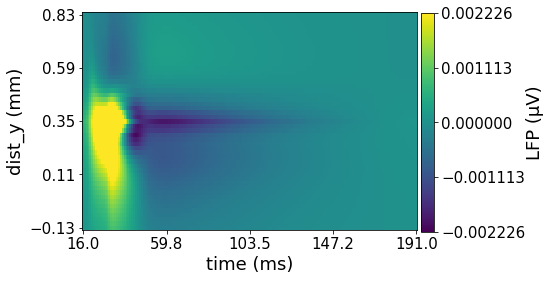

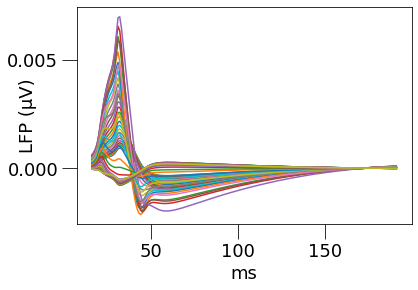

<Figure size 432x288 with 0 Axes>

<Figure size 1080x288 with 0 Axes>

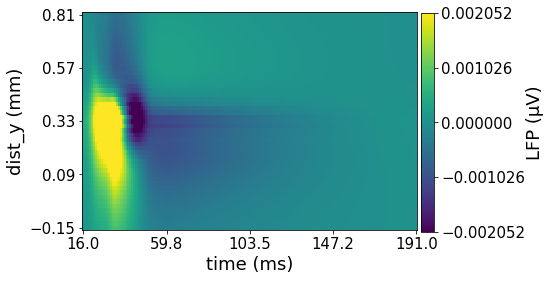

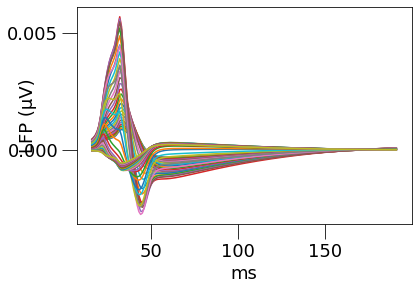

<Figure size 432x288 with 0 Axes>

In [10]:
%matplotlib inline

for j, df in enumerate(sty_data):
    #     if i < 20:
    #         continue
    fig=plt.figure(figsize=(15,4))
    #     In Vivo Plot
    fig, ax = plot_lfp_heatmap(t=t,
                               elec_d=sty_coordinates[j, e_idx, 1],
                               lfp=df.to_numpy()[:,e_idx],
                               vlim='auto',
                               fontsize=18, labelpad=0, ticksize=15, nbins=5
                               )

    fig, ax = plot_lfp_traces(t, df.to_numpy()[:,e_idx], fontsize=18)

    plt.tight_layout()

    # plt.savefig('lfp_heatmaps/' + 'detailed_groundtruth' + '.jpg')
#     if i == 22:
#         break
plt.show()

In [11]:
%matplotlib notebook
from cell_inference.utils.plotting.plot_morphology import plot_morphology

plot_morphology(sim, figsize=(10,10))

<IPython.core.display.Javascript object>

(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot:xlabel='z', ylabel='x'>)

In [12]:
display(summ_stats)
display(sty_summ_stats)

,Summary Stat 0,Summary Stat 1,Summary Stat 2,Summary Stat 3,Summary Stat 4,Summary Stat 5,Summary Stat 6,Summary Stat 7,Summary Stat 8,Summary Stat 9,...,Summary Stat 30,Summary Stat 31,Summary Stat 32,Summary Stat 33,Summary Stat 34,Summary Stat 35,Summary Stat 36,Summary Stat 37,Summary Stat 38,Summary Stat 39
0,-0.000040,0.000107,3.0,31.0,0.000021,0.0,24.0,-0.000606,-35.433673,84.729947,...,0.001144,16.0,56.0,130.0,22.0,28.0,22.0,26.0,33.0,27.0
1,-0.000007,0.000068,2.0,30.0,0.000139,0.0,24.0,-0.000240,-27.755102,82.903935,...,0.000505,16.0,42.0,117.0,21.0,27.0,21.0,26.0,31.0,26.0
2,0.000032,0.000068,1.0,23.0,0.000234,0.0,16.0,-0.000043,-23.729592,63.358660,...,0.000847,16.0,34.0,68.0,20.0,27.0,20.0,28.0,22.0,27.0
3,0.000003,0.000011,2.0,26.0,0.000033,0.0,24.0,-0.000059,37.811224,41.020777,...,0.000282,16.0,33.0,78.0,21.0,25.0,22.0,26.0,32.0,22.0
4,0.000006,0.000019,1.0,24.0,0.000069,0.0,19.0,-0.000033,51.433673,49.333214,...,0.000364,16.0,42.0,79.0,21.0,28.0,21.0,28.0,26.0,21.0
5,0.000011,0.000021,2.0,24.0,0.000085,0.0,14.0,-0.000005,20.005102,78.931222,...,0.000463,16.0,38.0,78.0,21.0,27.0,21.0,28.0,25.0,21.0


,Summary Stat 0,Summary Stat 1,Summary Stat 2,Summary Stat 3,Summary Stat 4,Summary Stat 5,Summary Stat 6,Summary Stat 7,Summary Stat 8,Summary Stat 9,...,Summary Stat 30,Summary Stat 31,Summary Stat 32,Summary Stat 33,Summary Stat 34,Summary Stat 35,Summary Stat 36,Summary Stat 37,Summary Stat 38,Summary Stat 39
0,-0.000040,0.000051,0.0,39.0,0.000024,3.0,24.0,-0.000190,-8.816327,22.761786,...,0.007486,16.0,27.0,28.0,17.0,29.0,19.0,31.0,9.0,25.0
1,-0.000068,0.000088,3.0,41.0,0.000021,0.0,24.0,-0.000574,-10.178571,23.442151,...,0.019197,16.0,29.0,41.0,22.0,26.0,22.0,26.0,32.0,24.0
2,-0.000062,0.000079,3.0,41.0,0.000022,0.0,24.0,-0.000494,-9.903061,23.568090,...,0.016353,16.0,28.0,41.0,22.0,27.0,22.0,27.0,30.0,23.0
3,-0.000053,0.000066,3.0,41.0,0.000021,0.0,24.0,-0.000370,-10.255102,22.607255,...,0.012457,16.0,30.0,43.0,22.0,27.0,22.0,27.0,32.0,23.0
4,-0.000043,0.000054,3.0,39.0,0.000023,0.0,24.0,-0.000240,-8.948980,22.665884,...,0.008726,16.0,28.0,44.0,19.0,28.0,20.0,27.0,7.0,25.0
5,-0.000036,0.000048,2.0,39.0,0.000024,3.0,24.0,-0.000131,-8.974490,21.921808,...,0.006033,16.0,25.0,28.0,14.0,28.0,19.0,31.0,12.0,27.0
